# Computing station load using average PC6 consumption

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from collections import defaultdict
import numpy as np
import tqdm
from functools import lru_cache

%matplotlib inline

In [2]:
postcode_url = 'https://basisregistraties.arcgisonline.nl/arcgis/rest/services/BAG/BAGv2/MapServer/0/query?where=postcode%3D%27{postcode}%27&text=&objectIds=&time=&geometry=&geometryType=esriGeometryPoint&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=1&queryByDistance=&returnExtentsOnly=false&datumTransformation=&parameterValues=&rangeValues=&f=pjson'

@lru_cache(26*26*8)
def postcode_to_longlat(postcode):
    '''Convert postcode to longitude and latitude'''
    result = requests.get(postcode_url.format(postcode=postcode)).json()
    if len(result['features']) < 1:
        raise ValueError(f'postcode {postcode} yielded no results')
    return list(result['features'][0]['geometry'].values())[::-1]

In [3]:
stations = pd.read_csv('/home/joris/Downloads/Groningen Stations.csv')

In [4]:
stations.head()

,STATIONSNUMMER,Gemeente,BOUWJAAR,BEDRIJFSSTATUS,VERMOGEN_NOMINAAL_CAPACITEIT,RDX,RDY,LAT,LONG
0,GNG.ts0570,Groningen,2000.0,In bedrijf,630,233076.456252,580326.321621,53.203894,6.555670
1,GNG.ts0663,Groningen,1991.0,In bedrijf,400,229396.242152,581510.050675,53.214936,6.500533
2,GNG.ts0507,Groningen,1987.0,In bedrijf,400,229858.275159,581569.706668,53.215680,6.508339
3,GNG.ts0163,Groningen,1963.0,In bedrijf,400,233652.166225,581911.145609,53.218004,6.564664
4,GNG.ts0296,Groningen,1964.0,In bedrijf,315,231959.415220,580774.114638,53.208075,6.539109


In [5]:
# Transform multiple CSVs into 1 CSV with "year" column
total_df = pd.DataFrame()
for year in range(2010, 2018):
    df = pd.read_csv(f'/home/joris/Downloads/Enexis_kleinverbruiksgegevens_0101{year}.csv', sep=';', encoding='cp1252')
    df = df[(df.WOONPLAATS == 'GRONINGEN') & (df.PRODUCTSOORT == 'ELK')]
    df['JAAR'] = year
    total_df = total_df.append(df, ignore_index=True)

In [6]:
df = total_df
# Compute the total consumption of the area
df['SJV_TOTAAL'] = df.SJV_GEMIDDELD * df.AANSLUITINGEN_AANTAL
df.head()

,NETBEHEERDER,NETGEBIED,STRAATNAAM,POSTCODE_VAN,POSTCODE_TOT,WOONPLAATS,LANDCODE,PRODUCTSOORT,VERBRUIKSSEGMENT,LEVERINGSRICHTING_PERC,AANSLUITINGEN_AANTAL,FYSIEKE_STATUS_PERC,SOORT_AANSLUITING_PERC,SOORT_AANSLUITING,SJV_GEMIDDELD,SJV_LAAG_TARIEF_PERC,SLIMME_METER_PERC,JAAR,SJV_TOTAAL
0,Enexis B.V.,ENEXIS,Praediniussingel,9711AA,9711AG,GRONINGEN,NL,ELK,KVB,100,69,100,NaN,NaN,5851.0,37,0.0,2010,403719.0
1,Enexis B.V.,ENEXIS,Ganzevoortsingel,9711AH,9711AJ,GRONINGEN,NL,ELK,KVB,100,29,100,NaN,NaN,1861.0,3,0.0,2010,53969.0
2,Enexis B.V.,ENEXIS,Ganzevoortsingel,9711AK,9711AK,GRONINGEN,NL,ELK,KVB,100,14,100,NaN,NaN,2064.0,31,0.0,2010,28896.0
3,Enexis B.V.,ENEXIS,Ganzevoortsingel,9711AL,9711AL,GRONINGEN,NL,ELK,KVB,100,14,100,NaN,NaN,1671.0,20,0.0,2010,23394.0
4,Enexis B.V.,ENEXIS,Ganzevoortsingel,9711AM,9711AM,GRONINGEN,NL,ELK,KVB,100,10,100,NaN,NaN,3202.0,22,0.0,2010,32020.0


## Find the stations closest to the area

In [ ]:
for year in tqdm.trange(2016, 2018, leave=False):
    df_year = df[df.JAAR == year]
    station_pos = stations[['LAT', 'LONG']].as_matrix()
    verbruik_per_station = [0]*len(stations)
    for _, row in df_year.iterrows():
        try:
            verbruik_loc = postcode_to_longlat(row.POSTCODE_VAN)
        except ValueError:
            continue
        closest_stations = np.argsort(np.linalg.norm(verbruik_loc - station_pos, axis=1))
        for idx in closest_stations:
            if stations.BOUWJAAR[idx] < year:
                break
        verbruik_per_station[idx] += row.SJV_TOTAAL
    stations[f'VERBRUIK_{year}'] = verbruik_per_station

In [17]:
def peak_power(verbruik):
    '''Compute the Strand-Axelsson equation to convert average consumption to peak load'''
    return 0.0002217 * verbruik + 0.0269 * np.sqrt(verbruik)

In [18]:
for year in range(2010, 2017):
    stations[f'PEAK_{year}'] = peak_power(stations[f'VERBRUIK_{year}'])

## Estimating future peak load using linear regression

In [92]:
from sklearn.linear_model import LinearRegression

peaks_per_year = {y: [] for y in range(2016, 2029)}
for _, row in stations.iterrows():
    peaks = row.iloc[16:22]
    years = np.arange(2010, 2016)
    model = LinearRegression().fit(years.reshape(-1, 1), peaks.values.astype(float))
    for year in range(2016, 2029):
        estimated_peak = model.predict([[year]])[0]
        peaks_per_year[year].append(estimated_peak)

for year, peaks in peaks_per_year.items():
    stations[f'FORECAST_PEAK_{year}'] = peaks

## Adding the projected load produced by solar panels

In [137]:
import json
for year in range(2017, 2028):
    solar_panel_power = {int(k): v for k, v in json.load(open(f'toadd_{year}.json')).items()}
    to_add = np.zeros(len(stations))
    for idx, value in solar_panel_power.items():
        to_add[idx] += value
    stations[f'FORECAST_SOLAR_PEAK_{year}'] = stations[f'FORECAST_PEAK_{year}'] + to_add

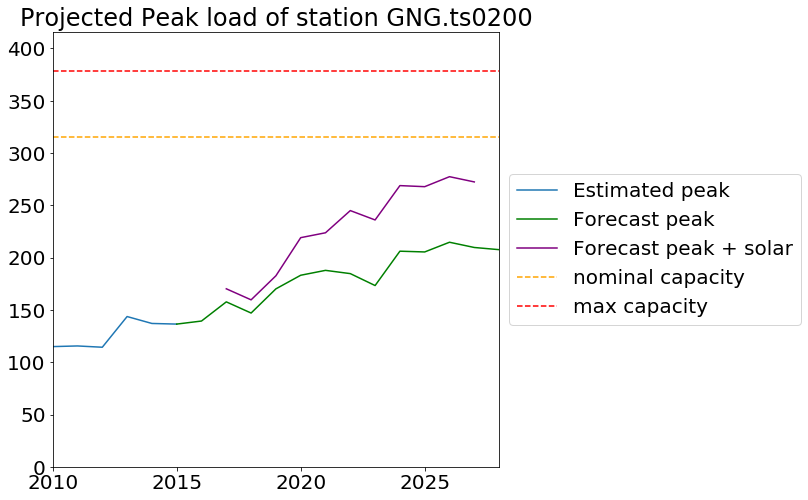

In [190]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

for i in [131]: # np.random.choice(list(solar_panel_power.keys()), size=15):
    plt.figure(figsize=(8, 8))
    plt.plot(list(range(2010, 2016)), stations.iloc[i, 16:22], label='Estimated peak')
    data = stations.iloc[i, 24:37]
    plt.plot(list(range(2015, 2029)), np.concatenate([[stations.iloc[i, 21]], np.clip(data, 0, float('inf'))]), '-', c='green', label='Forecast peak')
    plt.plot(list(range(2017, 2028)), stations.iloc[i, 37:].values, '-', c='purple', label='Forecast peak + solar')
    
    plt.plot([2010, 2028], [stations.VERMOGEN_NOMINAAL_CAPACITEIT[i]]*2, '--', c='orange', label='nominal capacity')
    plt.plot([2010, 2028], [stations.VERMOGEN_NOMINAAL_CAPACITEIT[i]*1.2]*2, '--', c='red', label='max capacity')
    plt.ylim([0, max(stations.iloc[i, 16:22].max(), stations.iloc[i, 24:37].max(), stations.VERMOGEN_NOMINAAL_CAPACITEIT[i]*1.2)*1.1])
    plt.xlim([2010, 2028])

    plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Projected Peak load of station {stations.STATIONSNUMMER[i]}')
    plt.savefig('projected_solar.png', dpi=300, bbox_inches='tight')
    plt.show()

In [193]:
stations.to_csv('stations.csv', index=False)